**Soil-air interface.**

Using the functionality of COMETS, one can design simulations which go beyond in silico corollaries of lab experiments to make predictions for environments mimicking natural ecosystems, which is a necessary step for understanding natural ecology from first principles. In this example, we consider a simulation of a soil environment. We use source-and-sink functions to model how a root provides organic acids to the environment while removing ammonia (Huang et al 2014 Botany). While we restrict the root functionality to a source/sink, one could use functionality demonstrated above, for example extracellular enzymes, to generate feedback loops between microbe-produced metabolites and root exudation. We use fixed metabolite concentrations to mimic the largely unchanging air interface above a root, which generates an oxygen gradient. Additionally, since soil is characterized by strong spatial structure with many impenetrable barriers that localized interactions (Nunan 2017), we place “rock” barriers throughout the simulation area. A more complex simulation could use varying diffusion constants for metabolites, as described in a previous protocol (Virtual Petri Dish). Similarly, we use standard diffusion of biomass, but this could be changed to use pushing force or non-linear diffusion for a potentially increased realism.

In [1]:
import cobra
import cobra.test # for the ijo1366 model
import sys
import copy
import numpy as np
sys.path.append("/home/jeremy/Dropbox/work_related/harcombe_lab/segre/cometspy")
import cometspy as c

Para nuestro proyecto, utilizaremos Escherichia coli (modelo iAF1260), Pseudomonas putida (modelo iJN1463) y Saccharomyces Cerevisiae (modelo iMM904), recuperados de la base de datos BIGG.

Cambiamos los bounds de las funciones objetivo de los modelos:

In [2]:
model_dir = "./modelos" # model location
iAF = cobra.io.read_sbml_model(model_dir + '/iAF1260.xml')
iAF.reactions.get_by_id('BIOMASS_Ec_iAF1260_core_59p81M').lower_bound = 0
iAF.reactions.get_by_id('BIOMASS_Ec_iAF1260_core_59p81M').upper_bound = 1000

iJN = cobra.io.read_sbml_model(model_dir + '/iJN1463.xml')
iJN.reactions.get_by_id('BIOMASS_KT2440_WT3').lower_bound = 0
iJN.reactions.get_by_id('BIOMASS_KT2440_WT3').upper_bound = 1000

iMM = cobra.io.read_sbml_model(model_dir + '/iMM904.xml')
iMM.reactions.get_by_id('BIOMASS_SC5_notrace').lower_bound = 0
iMM.reactions.get_by_id('BIOMASS_SC5_notrace').upper_bound = 1000

Luego se convierten estos modelos al formato de COMETS. Se utilizan funciones helper para dos cosas: a) Asegurar que el modelo en COMETS no confunda las reacciones de "sink" con las de exchange, ya que en COBRA están desbalanceadas y por tanto se parecen a las de exchange, y b) abrir todos los bounds de las reacciones de exchange, para que COMETS controle la composición del medio.

In [3]:
iAF_comets = c.model(iAF)
iAF_comets.ensure_sinks_are_not_exchanges()
iAF_comets.open_exchanges()

iJN_comets = c.model(iJN)
iJN_comets.ensure_sinks_are_not_exchanges()
iJN_comets.open_exchanges()

iMM_comets = c.model(iMM)
iMM_comets.ensure_sinks_are_not_exchanges()
iMM_comets.open_exchanges()

El mundo que se simulará tendrá dimensiones de 30x30. El eje de la izquierda (x = 0) corresponde a la raíz, y el eje superior (y = 0) corresponde al aire. La biomasa y las rocas se distribuyen en el resto del grid. Donde hayan rocas no puede haber ni biomasa ni metabolitos, así que seleccionamos esos lugares primero. Para esta simulación, se generarán 50 rocas con un un tamaño medio de 5 cuadraditos. Para generar las piedras se utiliza la función helper grow_rocks.

In [4]:
from cometspy.utils import grow_rocks, pick_random_locations

grid_size = 15 # 100
n_rocks = 15 # 70
rock_locs = grow_rocks(n = n_rocks, xrange = [1,grid_size-1],yrange = [1,grid_size-1],mean_size = 5)

Cada especie será plantada en 20 lugares sin sobreponerse. Para esto se utiliza la función helper pick_random_locations, la cual toma como argumento una tupla generada anteriormente que marca lugares "prohibidos", como los cuadrados donde se encuentran las rocas. 

Generamos una copia de rock_locs para no cambiarla accidentalmente, y la llamamos forbbiden_locs:

In [5]:
import copy
forbidden_locs = copy.deepcopy(rock_locs)

Ahora elegimos al azar los lugares para cada especie, y los vamos añadiendo a la lista forbidden locs para que no se sobrepongan:

In [6]:
founders_per_species = 10 # 60
iAF_locs = pick_random_locations(n = founders_per_species, 
                                   xrange = [1,grid_size], yrange = [1,grid_size], 
                                   forbidden_locs = forbidden_locs)
forbidden_locs.extend(iAF_locs)
iJN_locs = pick_random_locations(founders_per_species, [1,grid_size],[1,grid_size], forbidden_locs)
forbidden_locs.extend(iJN_locs)
iMM_locs = pick_random_locations(founders_per_species, [1,grid_size],[1,grid_size], forbidden_locs)
forbidden_locs.extend(iMM_locs)

Para graficar los lugares utilizamos matplotlib:

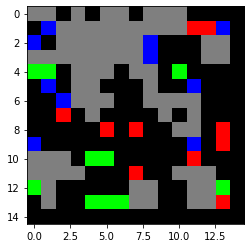

In [7]:
from matplotlib import pyplot as plt
initial_image = np.zeros((grid_size,grid_size,3))
for rock in rock_locs:
    initial_image[rock[1]-1,rock[0]-1,0:3] = 0.5 
for loc in iAF_locs:
    initial_image[loc[1]-1,loc[0]-1,0] = 1
for loc in iJN_locs:
    initial_image[loc[1]-1,loc[0]-1,1] = 1
for loc in iMM_locs:
    initial_image[loc[1]-1,loc[0]-1,2] = 1
plt.imshow(initial_image)

Generamos el layout y agregamos las rocas:

In [8]:
layout = c.layout()
layout.grid = [grid_size,grid_size]
layout.add_barriers(rock_locs)

building empty layout model
models will need to be added with layout.add_model()


Setteamos las poblaciones iniciales para cada especie, con esto los modelos están listos y los añadimos al layout:

In [9]:
iAF_comets.initial_pop = [[loc[0],loc[1],1e-8] for loc in iAF_locs]
iJN_comets.initial_pop = [[loc[0],loc[1],1e-8] for loc in iJN_locs]
iMM_comets.initial_pop = [[loc[0],loc[1],1e-8] for loc in iMM_locs]

layout.add_model(iAF_comets)
layout.add_model(iJN_comets)
layout.add_model(iMM_comets)

Añadimos los metabolitos que estarán inicialmente disponibles en el ambiente. Usamos la función helper add_typical_trace_metabolites() para las trazas típicas. Bajamos el valor del oxígeno dado que la idea es que el que esté disponible difunda desde la atmósfera. Añadimos algunos metabolitos que no se añadieron con la función helper:

In [10]:
layout.add_typical_trace_metabolites()
layout.set_specific_metabolite('o2_e',0.00001)
layout.set_specific_metabolite('hco3_e',1000)
layout.set_specific_metabolite('co2_e',1000)
layout.set_specific_metabolite('h2_e',1000)
layout.set_specific_metabolite('so3_e',1000)
layout.set_specific_metabolite('nh4_e',0.000001)

layout.set_specific_metabolite('glc__D_e',0.0000001)
layout.set_specific_metabolite('meoh_e',0.00000001)
layout.set_specific_metabolite('cys__L_e',0.0000001)
layout.set_specific_metabolite('4abz_e',0.0000001)
layout.set_specific_metabolite('nac_e',0.00000001)
layout.set_specific_metabolite('catechol_e',0.0000001)

Para la capa de aire, dejamos el oxígeno en un valor constante. Al fondo también dejamos al oxígeno en un valor fijo e igual a 0, para simular el efecto de difusión. De manera similar, hacemos lo mismo con el amoniaco y la raíz en la parte izquierda:

In [11]:
# set static media of O2 and CO2 at the top and bottom-- the "air" and continuous loss of O2 downwards
for x in range(grid_size):
    layout.set_specific_static_at_location('o2_e', (x,0), .0001) # top
    layout.set_specific_static_at_location('o2_e', (x,grid_size-1), 0.) # bottom
    layout.set_specific_static_at_location('co2_e', (x,0), .0001)
    
for x in range(grid_size):
    layout.set_specific_static_at_location('nh4_e', (0,x), 0.0)

La raíz consume todo el amoniaco, pero es una fuente de acidos orgánicos y metanol para el ambiente. Asumiendo una tasa fija:

In [12]:
for x in range(grid_size):
    layout.set_specific_refresh_at_location('cit_e', (0,x), .000001)
    layout.set_specific_refresh_at_location('meoh_e', (0,x), .000001)
    layout.set_specific_refresh_at_location('succ_e', (0,x), .000001)

El layout y los modelos están listos, ahora setteamos los parámetros de la simulación:

In [13]:
params = c.params()
params.set_param('timeStep', 0.1)
params.set_param('maxCycles', 1000)
params.set_param('maxSpaceBiomass', 10)
params.set_param('deathRate', 0.0001) # die at rate of 1/10000 per hour
params.set_param('writeBiomassLog', True)
params.set_param('BiomassLogRate', 500)
params.set_param('writeMediaLog', True)
params.set_param('MediaLogRate', 500)
params.set_param("writeFluxLog", True)
params.set_param("FluxLogRate", 500)
params.set_param('numRunThreads', 3)
params.set_param('defaultKm', 0.000001)

Ahora creamos el objeto de la simulación y la corremos. Ojito que se demora y el pc empieza a despegar.

In [14]:
sim = c.comets(layout, params)
sim.run(False)


Running COMETS simulation ...


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (5,8,9,10,18,45,58,75,81,82,84,102,104,108,110,116,126,127,156,167,170,189,199,206,249,251,255,266,267,271,276,277,287,301,306,310,312,328,350,369,378,380,381,388,390,401,420,421,422,430,432,463,467,478,485,486,498,506,511,522,540,541,552,562,563,565,584,587,600,605,636,638,646,651,655,659,660,665,666,669,696,702,703,712,718,722,726,730,740,743,745,753,756,761,789,791,796,806,817,825,826,827,829,836,843,847,866,892,903,904,914,916,933,937,939,943,970,972,975,976,979,999,1001,1005,1015,1021,1023,1031,1040,1053,1058,1063,1064,1065,1071,1086,1107,1112,1114,1118,1119,1124,1125,1182,1189,1190,1204,1213,1214,1217,1231,1237,1261,1277,1285,1292,1304,1306,1307,1315,1316,1333,1334,1337,1347,1349,1358,1376,1412,1422,1439,1442,1448,1451,1455,1461,1462,1472,1485,1499,1509,1511,1520,1521,1526,1528,1560,1567,1570,1571,1572,1585,1587,1589,1590,1603,1605,1638,1644,1646,1664,1665,1666,1670,1676,1678,1

Done!


In [15]:
print(sim.run_output)

-script
running script file: C:\Users\ronal\Desktop\Proyecto ODRM\ODRM\simulaciones\3_modelos\grid_15/.current_script_0x27e8f1a9c70
Current Java version: 17.0.1
Parameters file .current_global_0x27e8f1a9c70 loaded.
Parameters file .current_package_0x27e8f1a9c70 loaded.
Loading layout file '.current_layout_0x27e8f1a9c70'...
null\COMETS_manifest.txt (El sistema no puede encontrar la ruta especificada)
Unable to initialize manifest file. 
Continuing without writing manifest file.
Found 3 model files!
Loading '.\iAF1260.cmd' ...
Academic license - for non-commercial use only - expires 2022-02-10
Academic license - for non-commercial use only - expires 2022-02-10
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
objective solution = 395.7352921962825
Loading '.\iJN1463.cmd' ...
Academic license - for non-commercial use only - expires 2022-02-10
Academic license - for non-commercial use only - expires 2022-02-10
Done!
 Testing default parameters...
Done!
Optimi

Para revisar la biomasa total 

<AxesSubplot:xlabel='cycle'>

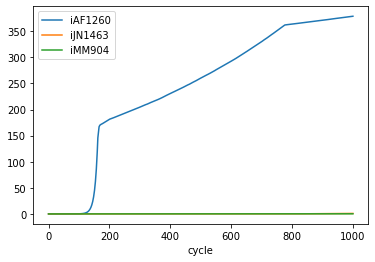

In [16]:
sim.total_biomass.plot(x = "cycle")

Graficamos los resultados de biomasa y demás metabolitos interesantes en el grid:

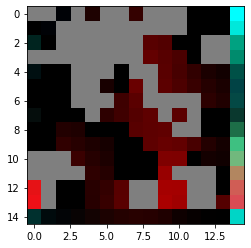

In [17]:
im = sim.get_biomass_image('iAF1260', params.all_params['maxCycles'])
im2 = sim.get_biomass_image('iJN1463',params.all_params['maxCycles'])
im3 = sim.get_biomass_image('iMM904',params.all_params['maxCycles'])

final = np.zeros((grid_size,grid_size,3))
final[:,:,0] = im / np.max(im)
final[:,:,1] = im2 / np.max(im2)
final[:,:,2] = im3 / np.max(im3)
for rock in rock_locs:
    final[rock[1]-1,rock[0]-1,0:3] = 0.5 
from matplotlib import pyplot as plt
plt.imshow(final)

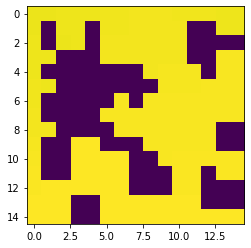

In [18]:
plt.imshow(sim.get_metabolite_image("succ_e",params.all_params['maxCycles']))

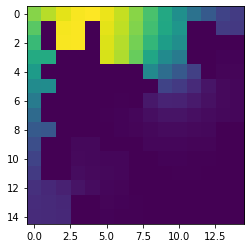

In [19]:
plt.imshow(sim.get_metabolite_image("ac_e",params.all_params['maxCycles']))

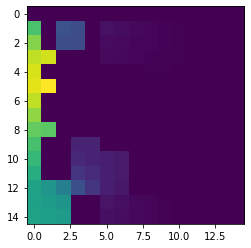

In [20]:
plt.imshow(sim.get_metabolite_image("nh4_e",params.all_params['maxCycles']))

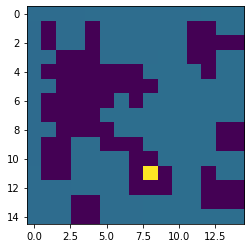

In [21]:
plt.imshow(sim.get_metabolite_image("catechol_e",params.all_params['maxCycles']))